In [1]:
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler
import src.util as util
import yaml
import copy
from tqdm import tqdm
import os
from datetime import datetime

In [2]:
config_data=util.config_load()

In [3]:
df_inp=util.pickle_load(config_data['raw_dataset_path_train_inp'])
df_outp=util.pickle_load(config_data['raw_dataset_path_train_outp'])

In [ ]:
inp_unq = set(df_inp['BeneID'])
outp_unq = set(df_outp['BeneID'])

In [ ]:
inp_only=inp_unq.intersection(outp_unq)
outp_only=outp_unq.difference(inp_unq)

In [ ]:
print(len(inp_only))
print(len(outp_only))

26713
107267


In [ ]:
Total_counts = pd.DataFrame([len(inp_only), len(outp_only)]).T
Total_counts.columns = ['In-patients Only', 'Out-patients Only']
Total_p_counts=len(inp_only)+ len(outp_only)
Total_counts

,In-patients Only,Out-patients Only
0,26713,107267


In [ ]:
Total_p_counts

133980

[]

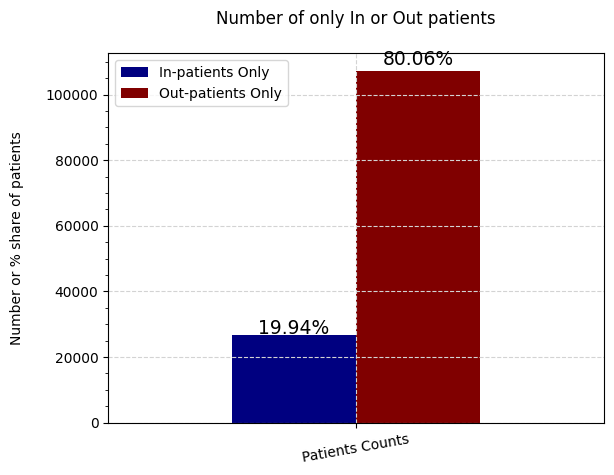

In [ ]:
fig=Total_counts.plot(kind='bar',colormap='jet')
for p in fig.patches:
    height=p.get_height()
    width=p.get_width()
    x,y=p.get_xy()
    fig.annotate(f'{str(round((height*100)/Total_p_counts,2))+"%"}',(x+width/2,y+height*1.015),ha='center',fontsize=13.5)
#fig.annotate(f'{str(round((height*100)/tot_patients,2))+"%"}', (x + width/2, y + height*1.015), ha='center', fontsize=13.5)
plt.xticks(labels=["Patients Counts"], ticks=[0], rotation=10)
plt.ylabel("Number or % share of patients\n")
plt.grid(which='major', linestyle="--", color='lightgrey')
plt.minorticks_on()
plt.title("Number of only In or Out patients\n")
plt.plot()


About 80% of patients are just outpatients who are treater without admit. This could be an important feature.

**Inpatient Analysis**

[]

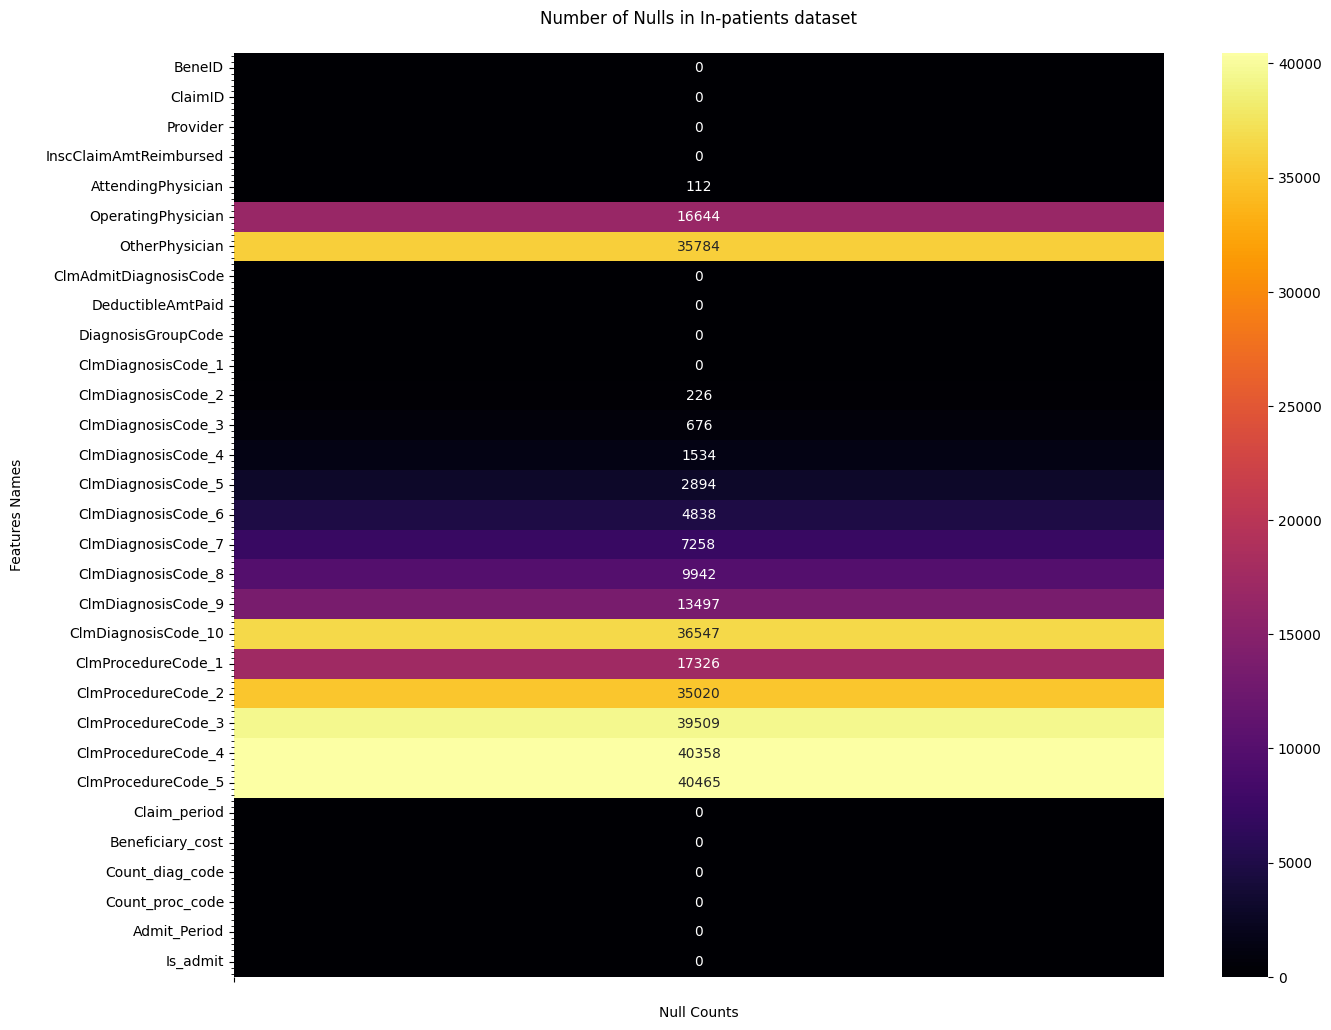

In [ ]:
plt.figure(figsize=(15,12))
fig = sns.heatmap(pd.DataFrame(df_inp.isnull().sum()), annot=True, fmt=".7g", cmap='inferno', cbar=True)
    # Providing the labels and title to the graph
plt.xticks(labels=[" "], ticks=[0])
plt.xlabel("Null Counts")
plt.ylabel("Features Names\n")
plt.minorticks_on()
plt.title("Number of Nulls in In-patients dataset\n")
plt.plot()

Claim diagnosis code 10 is very rare. Claim procedure code 4 and 5 are rare as well. However, we need to check other details to take any decisions to remove them.

**Admitted and claim duration with reimbursed amount**

In [ ]:
df_claimprd_grt_thn_admprd=df_inp[df_inp.Claim_period>df_inp.Admit_Period]

In [ ]:
df_claimprd_grt_thn_admprd

,BeneID,ClaimID,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DiagnosisGroupCode,...,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,Claim_period,Beneficiary_cost,Count_diag_code,Count_proc_code,Admit_Period,Is_admit
35,BENE11093,CLM82202,PRV51842,20000,PHY341192,PHY355416,NaN,4439,1068,255,...,2762.0,NaN,NaN,NaN,9,18932,10,2,6,1
3864,BENE24807,CLM82212,PRV54111,13000,PHY360669,PHY408812,NaN,55221,1068,345,...,NaN,NaN,NaN,NaN,11,11932,9,1,9,1
7752,BENE39346,CLM82211,PRV54065,19000,PHY337531,PHY341176,NaN,44421,1068,254,...,NaN,NaN,NaN,NaN,8,17932,10,1,5,1
9094,BENE44545,CLM82209,PRV52843,14000,PHY365072,NaN,NaN,85181,1068,023,...,NaN,NaN,NaN,NaN,9,12932,9,0,7,1
9974,BENE47786,CLM82208,PRV52828,14000,PHY391167,NaN,NaN,486,1068,166,...,NaN,NaN,NaN,NaN,8,12932,7,0,5,1
17060,BENE73681,CLM82213,PRV54354,11000,PHY397703,NaN,PHY390453,78079,1068,315,...,NaN,NaN,NaN,NaN,11,9932,9,0,8,1
18267,BENE78133,CLM82210,PRV53461,20000,PHY331754,PHY426843,NaN,72981,1068,228,...,NaN,NaN,NaN,NaN,3,18932,3,1,1,1
21298,BENE88968,CLM82205,PRV52045,24000,PHY339550,PHY359571,NaN,78650,1068,304,...,NaN,NaN,NaN,NaN,5,22932,9,1,2,1
26395,BENE107828,CLM82216,PRV55018,19000,PHY364322,PHY320450,NaN,78900,1068,439,...,7850.0,NaN,NaN,NaN,21,17932,10,2,18,1
27053,BENE110116,CLM82217,PRV56268,20000,PHY400645,PHY408610,NaN,25010,1068,642,...,NaN,NaN,NaN,NaN,36,18932,9,1,35,1


In [ ]:
df_claimprd_grt_thn_admprd['InscClaimAmtReimbursed'].sum()

np.int64(274000)

There are 17 claims with higher duration on claim than admitted duration. However, the amount is not much of a concern

**Distribution of claim duration with reimbursed amount**

In [5]:
df_clm_du_reim_amt=df_inp.groupby('Claim_period')['InscClaimAmtReimbursed'].mean().reset_index()

In [6]:
df_clm_du_reim_amt

,Claim_period,InscClaimAmtReimbursed
0,0,6487.603306
1,1,7252.881061
2,2,7188.692597
3,3,8186.325554
4,4,8798.856399
5,5,9489.365745
6,6,10706.562270
7,7,11555.294118
8,8,12802.481390
9,9,13070.502600


In [7]:
df_clm_du_reim_amt=pd.DataFrame(df_clm_du_reim_amt)
df_clm_du_reim_amt.columns=['Claim_period','Reimbursement_amount']

[]

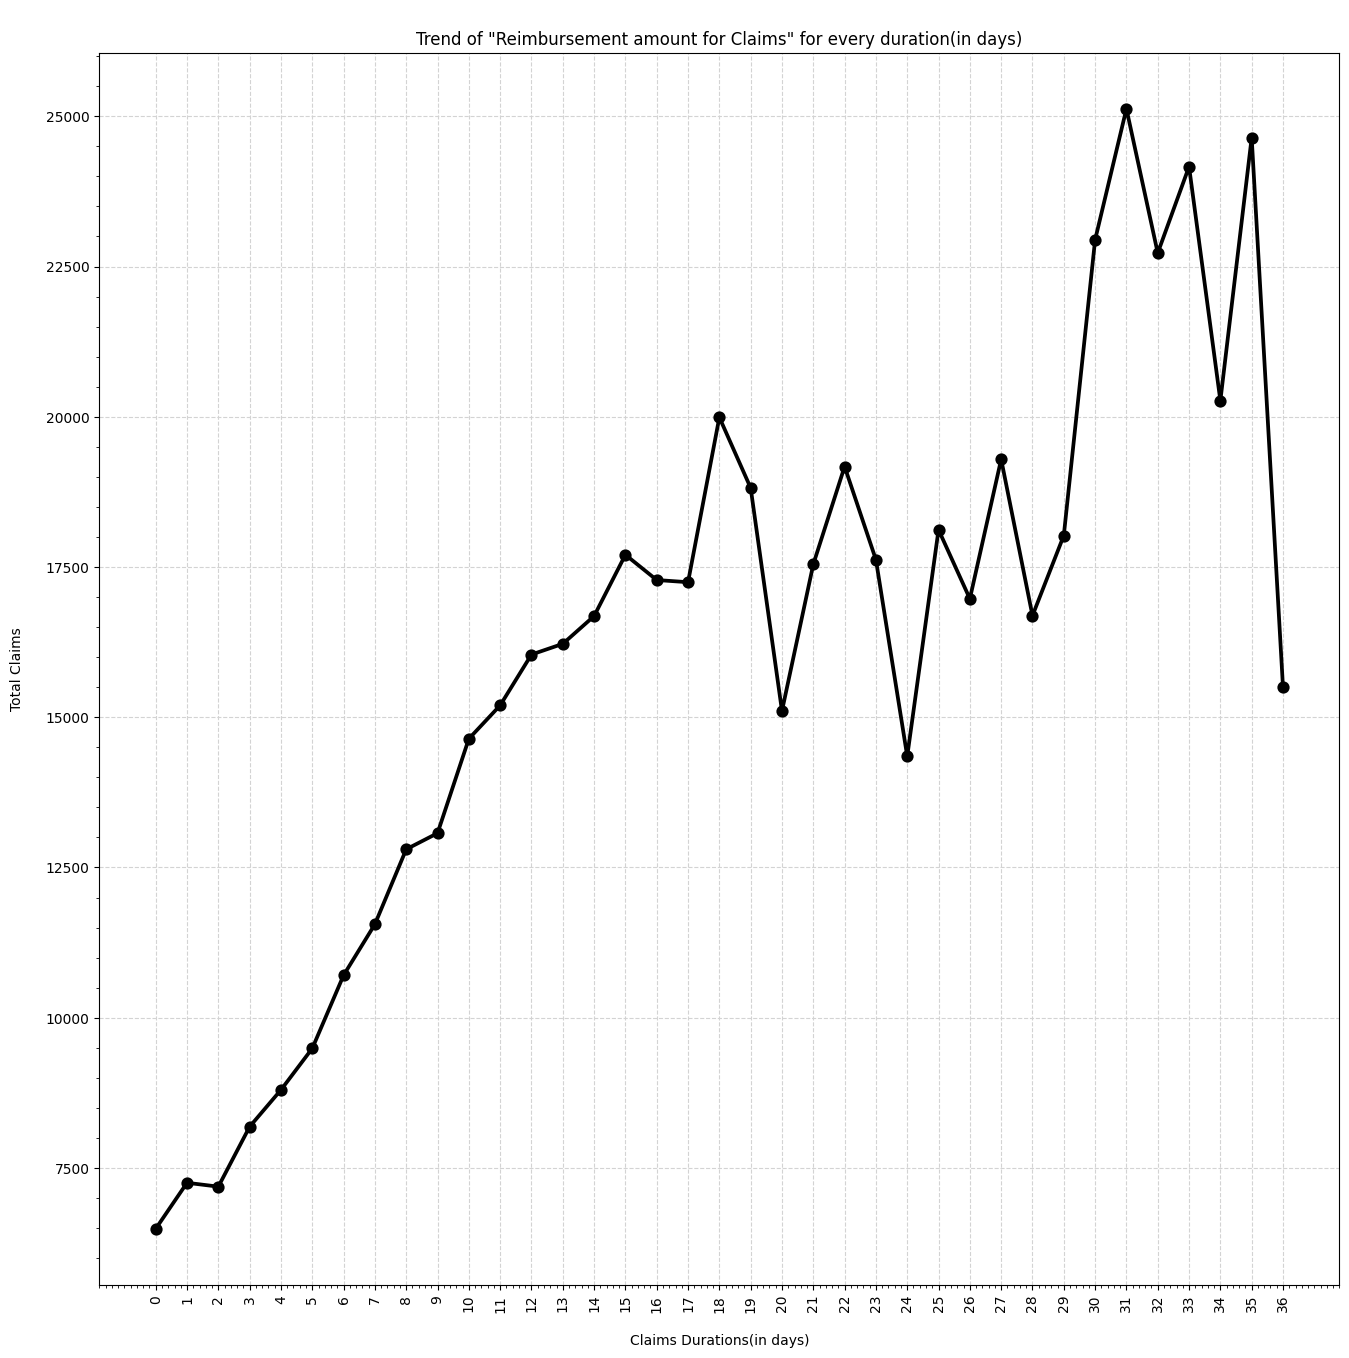

In [8]:
plt.figure(figsize=(16,16))
sns.pointplot(data=df_clm_du_reim_amt, x='Claim_period', y='Reimbursement_amount', 
                  color='k', markers="o", linestyles="-")

     
    # Providing the labels and title to the graph
plt.xticks(rotation=90)
plt.xlabel("\nClaims Durations(in days)")
plt.ylabel("Reimbursement Amount\n")
plt.grid(which='major', linestyle="--", color='lightgrey')
plt.minorticks_on()
plt.title('\nTrend of "Reimbursement amount for Claims" for every duration(in days)')
plt.plot()

There is an upward trend in the average reimbursement amount when the claims duration increases.

In [ ]:
df_clm_du_clm_cnt=df_inp.groupby('Claim_period')['ClaimID'].count().reset_index()

In [ ]:
df_clm_du_clm_cnt

,Claim_period,ClaimID
0,0,605
1,1,4599
2,2,6119
3,3,6899
4,4,4993
5,5,3579
6,6,2714
7,7,2210
8,8,1612
9,9,1154


In [ ]:
df_clm_du_clm_cnt=pd.DataFrame(df_clm_du_clm_cnt)
df_clm_du_clm_cnt.columns=['Claim_period','Count']

In [ ]:
df_clm_du_clm_cnt

,Claim_period,Count
0,0,605
1,1,4599
2,2,6119
3,3,6899
4,4,4993
5,5,3579
6,6,2714
7,7,2210
8,8,1612
9,9,1154


[]

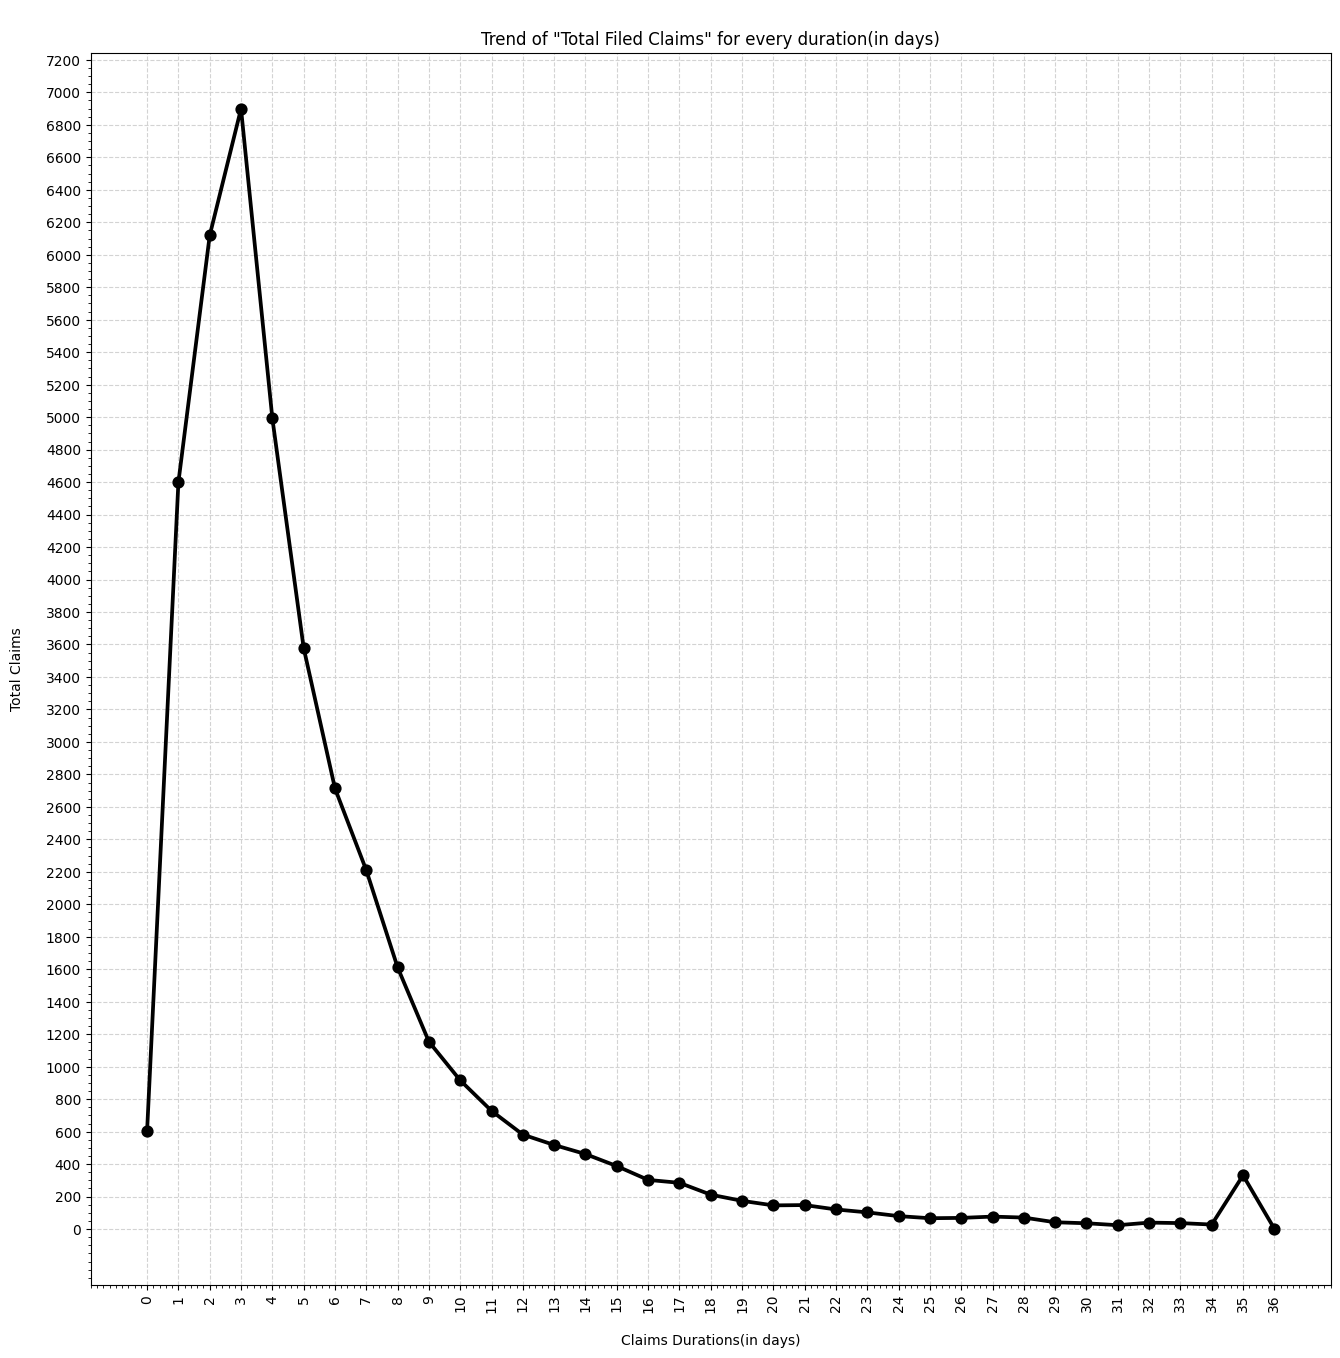

In [ ]:
plt.figure(figsize=(16,16))
sns.pointplot(data=df_clm_du_clm_cnt, x='Claim_period', y='Count', 
                  color='k', markers="o", linestyles="-")

     
    # Providing the labels and title to the graph
plt.xticks(rotation=90)
plt.xlabel("\nClaims Durations(in days)")
plt.ylabel("Total Claims\n")
plt.yticks(np.arange(0,7500,200))
plt.grid(which='major', linestyle="--", color='lightgrey')
plt.minorticks_on()
plt.title('\nTrend of "Total Filed Claims" for every duration(in days)')
plt.plot()

**Provider Level**

In [9]:
provider_tot_claims_filed = pd.DataFrame(df_inp.groupby(['Provider'])['ClaimID'].count())
provider_tot_reimbursed_amt = pd.DataFrame(df_inp.groupby(['Provider'])['InscClaimAmtReimbursed'].sum())

prv_tot_filed_claims_and_tot_reimb_amt = pd.merge(left=provider_tot_claims_filed, right=provider_tot_reimbursed_amt, how='inner',
                                                  left_on=provider_tot_claims_filed.index, right_on=provider_tot_reimbursed_amt.index)

prv_tot_filed_claims_and_tot_reimb_amt.columns = ['ProviderID', 'Tot_Claims_Filed', 'Tot_Re_Imbursed_Amt']
prv_tot_filed_claims_and_tot_reimb_amt.reset_index(drop=True,inplace=True)
prv_tot_filed_claims_and_tot_reimb_amt['Percentage_out_of_tot_reimb_amt'] = round((prv_tot_filed_claims_and_tot_reimb_amt['Tot_Re_Imbursed_Amt'] / df_inp['InscClaimAmtReimbursed'].sum()) * 100, 3)

provider_max_reimbursed_amt = pd.DataFrame(df_inp.groupby(['Provider'])['InscClaimAmtReimbursed'].max())
provider_max_reimbursed_amt.rename(columns={"InscClaimAmtReimbursed": "Max_Re_Imbursed_Amt"}, inplace=True)

prv_tot_filed_claims_tot_max_reimb_amt = pd.merge(left=prv_tot_filed_claims_and_tot_reimb_amt, 
                                                  right=provider_max_reimbursed_amt, how='inner',
                                                  left_on=prv_tot_filed_claims_and_tot_reimb_amt['ProviderID'], 
                                                  right_on=provider_max_reimbursed_amt.index)

prv_tot_filed_claims_tot_max_reimb_amt.drop(['key_0'], axis=1, inplace=True)
prv_tot_filed_claims_tot_max_reimb_amt['Diff_in_Tot_and_Max'] = prv_tot_filed_claims_tot_max_reimb_amt['Tot_Re_Imbursed_Amt'] - prv_tot_filed_claims_tot_max_reimb_amt['Max_Re_Imbursed_Amt']

prv_tot_filed_claims_tot_max_reimb_amt.head()

,ProviderID,Tot_Claims_Filed,Tot_Re_Imbursed_Amt,Percentage_out_of_tot_reimb_amt,Max_Re_Imbursed_Amt,Diff_in_Tot_and_Max
0,PRV51001,5,97000,0.024,42000,55000
1,PRV51003,62,573000,0.140,57000,516000
2,PRV51007,3,19000,0.005,10000,9000
3,PRV51008,2,25000,0.006,21000,4000
4,PRV51011,1,5000,0.001,5000,0


In [11]:
prv_tot_filed_claims_tot_max_reimb_amt.sort_values(by=['Diff_in_Tot_and_Max','Max_Re_Imbursed_Amt','Percentage_out_of_tot_reimb_amt'],
                                                   axis=0, inplace=True,
                                                   ascending=[True, False, False])

In [14]:
prv_tot_filed_claims_tot_max_reimb_amt.head(60)

,ProviderID,Tot_Claims_Filed,Tot_Re_Imbursed_Amt,Percentage_out_of_tot_reimb_amt,Max_Re_Imbursed_Amt,Diff_in_Tot_and_Max
574,PRV52518,1,57000,0.014,57000,0
578,PRV52537,1,57000,0.014,57000,0
1767,PRV56664,1,57000,0.014,57000,0
1883,PRV57080,1,57000,0.014,57000,0
2012,PRV57399,1,57000,0.014,57000,0
1970,PRV57290,2,55000,0.013,55000,0
305,PRV51681,1,51000,0.012,51000,0
637,PRV52804,1,36000,0.009,36000,0
286,PRV51626,1,35000,0.009,35000,0
11,PRV51035,1,29000,0.007,29000,0


Highest claims reimbursed amount% consist of the providers who raised 1 or 2 claims. These could be potential fraudulent cases.

In [15]:
tot_re_imb_amt_for_prv_with_5orless_claims = prv_tot_filed_claims_tot_max_reimb_amt[prv_tot_filed_claims_tot_max_reimb_amt['Tot_Claims_Filed'] < 5] ['Tot_Re_Imbursed_Amt'].sum()

pp_re_imb_amt_for_prv_with_5orless_claims = round((tot_re_imb_amt_for_prv_with_5orless_claims / df_inp['InscClaimAmtReimbursed'].sum()) * 100,2)
print("### Total Re-imbursed Amount for Providers with less than 5 filed claims is --> {} (17 Million). ###\n\
### And, this is {}% of Total Re-imbursed Claim Amount (408 Million). ###".format(tot_re_imb_amt_for_prv_with_5orless_claims, 
                                                                    pp_re_imb_amt_for_prv_with_5orless_claims))

### Total Re-imbursed Amount for Providers with less than 5 filed claims is --> 17012550 (17 Million). ###
### And, this is 4.17% of Total Re-imbursed Claim Amount (408 Million). ###


**Outpatient EDA**

In [20]:
df_outp.columns

Index(['BeneID', 'ClaimID', 'Provider', 'InscClaimAmtReimbursed',
       'AttendingPhysician', 'OperatingPhysician', 'OtherPhysician',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'DeductibleAmtPaid', 'ClmAdmitDiagnosisCode', 'Claim_period',
       'Beneficiary_cost', 'Count_diag_code', 'Count_proc_code', 'Is_admit'],
      dtype='object')

[]

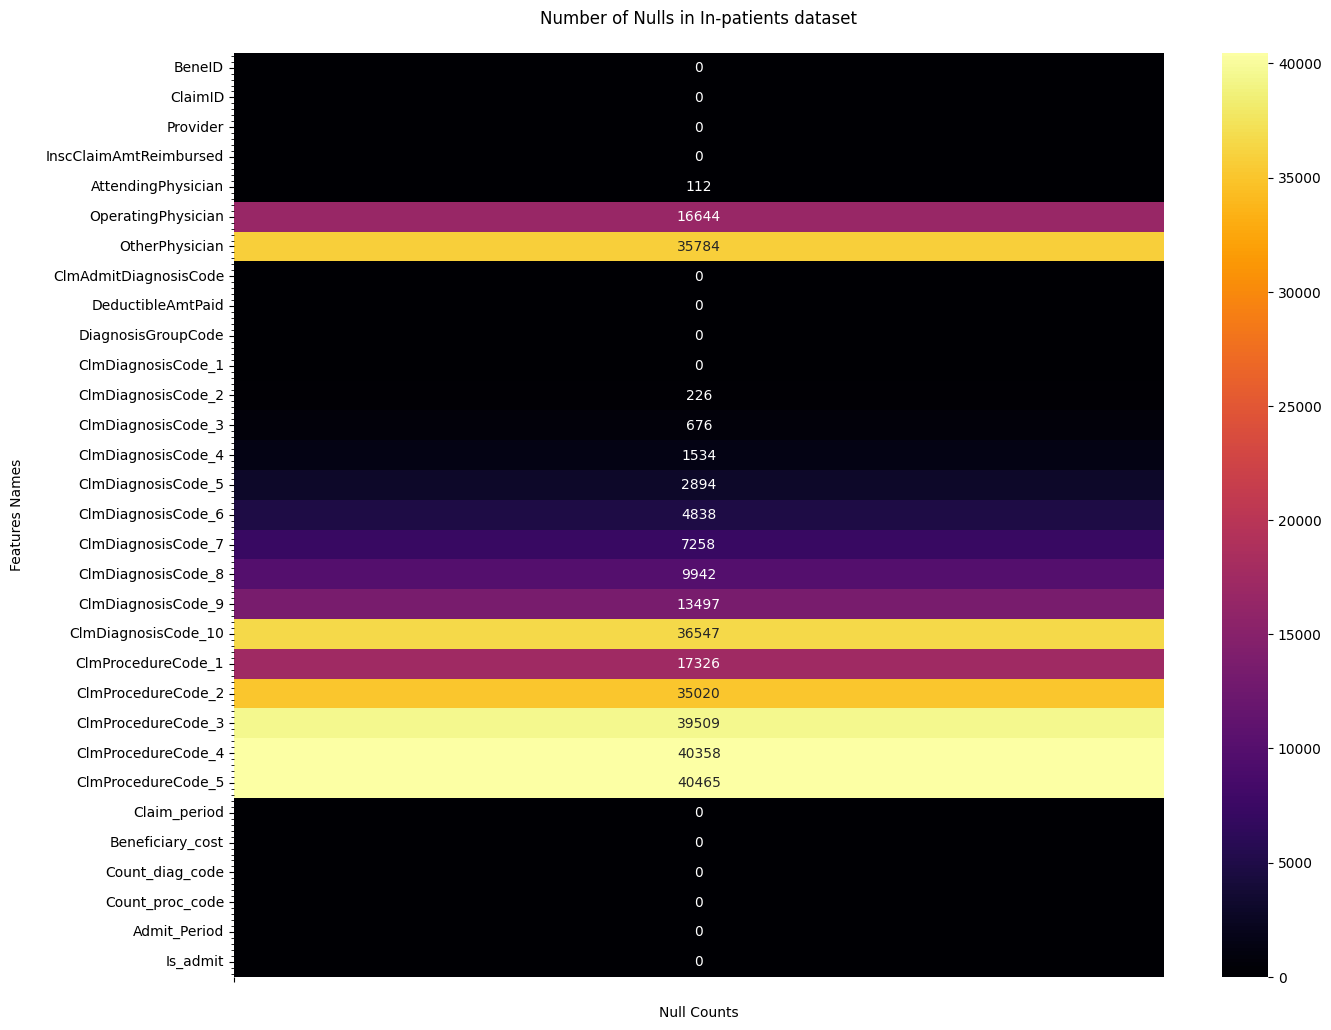

In [21]:
plt.figure(figsize=(15,12))
fig = sns.heatmap(pd.DataFrame(df_outp.isnull().sum()), annot=True, fmt=".7g", cmap='inferno', cbar=True)
    # Providing the labels and title to the graph
plt.xticks(labels=[" "], ticks=[0])
plt.xlabel("Null Counts")
plt.ylabel("Features Names\n")
plt.minorticks_on()
plt.title("Number of Nulls in out-patients dataset\n")
plt.plot()

In [27]:
for val in [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.93,0.95,0.96,0.97,0.99,1]:
    percentiles=round(float(val),6)
    percentile_vals=round(df_outp['Claim_period'].quantile(val),1)
    print("Percentile --> {} and its value is --> {}".format(percentiles,percentile_vals))

Percentile --> 0.0 and its value is --> 0.0
Percentile --> 0.1 and its value is --> 0.0
Percentile --> 0.2 and its value is --> 0.0
Percentile --> 0.3 and its value is --> 0.0
Percentile --> 0.4 and its value is --> 0.0
Percentile --> 0.5 and its value is --> 0.0
Percentile --> 0.6 and its value is --> 0.0
Percentile --> 0.7 and its value is --> 0.0
Percentile --> 0.8 and its value is --> 0.0
Percentile --> 0.9 and its value is --> 2.0
Percentile --> 0.93 and its value is --> 9.0
Percentile --> 0.95 and its value is --> 17.0
Percentile --> 0.96 and its value is --> 20.0
Percentile --> 0.97 and its value is --> 20.0
Percentile --> 0.99 and its value is --> 20.0
Percentile --> 1.0 and its value is --> 23.0


90% of claims are filed for less than 2 days.

In [29]:
for val in [0.1,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,0.999,0.9999,0.99999,0.999999,1.0]:
    percentile = round(float(val*100),6)
    percentile_val = round(df_outp["InscClaimAmtReimbursed"].quantile(val),1)
    print("Percentile --> {} and its value is --> {}".format(percentile,percentile_val))

Percentile --> 10.0 and its value is --> 10.0
Percentile --> 20.0 and its value is --> 30.0
Percentile --> 25.0 and its value is --> 40.0
Percentile --> 30.0 and its value is --> 40.0
Percentile --> 40.0 and its value is --> 60.0
Percentile --> 50.0 and its value is --> 80.0
Percentile --> 60.0 and its value is --> 100.0
Percentile --> 70.0 and its value is --> 200.0
Percentile --> 75.0 and its value is --> 200.0
Percentile --> 80.0 and its value is --> 300.0
Percentile --> 90.0 and its value is --> 700.0
Percentile --> 91.0 and its value is --> 800.0
Percentile --> 92.0 and its value is --> 900.0
Percentile --> 93.0 and its value is --> 1000.0
Percentile --> 94.0 and its value is --> 1200.0
Percentile --> 95.0 and its value is --> 1500.0
Percentile --> 96.0 and its value is --> 1800.0
Percentile --> 97.0 and its value is --> 2100.0
Percentile --> 98.0 and its value is --> 2500.0
Percentile --> 99.0 and its value is --> 3300.0
Percentile --> 99.9 and its value is --> 3500.0
Percentile 

95% of claims have been less than $3500.

[]

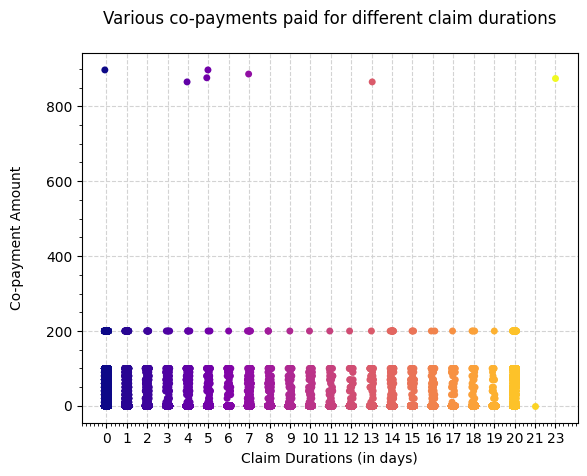

In [33]:
sns.stripplot(x="Claim_period", y="DeductibleAmtPaid", hue='Claim_period',legend=False, data=df_outp, palette="plasma")
# Providing the labels and title to the graph
plt.xlabel("Claim Durations (in days)")
plt.ylabel("Co-payment Amount\n")
plt.grid(which='major', linestyle="--", color='lightgrey')
plt.minorticks_on()
plt.title("Various co-payments paid for different claim durations\n")
plt.plot()

In [34]:
tot_claims_filed_for_specific_days = pd.DataFrame(df_outp.groupby(['Claim_period'])['ClaimID'].count())
tot_claims_filed_for_specific_days

,ClaimID
Claim_period,
0,453348
1,11960
2,4366
3,2597
4,2238
5,1511
6,1306
7,2564
8,1189


In [36]:
tot_insc_amount_for_claim_durations = pd.DataFrame(df_outp.groupby(['Claim_period'])['InscClaimAmtReimbursed'].sum())
tot_insc_amount_for_claim_durations

,InscClaimAmtReimbursed
Claim_period,
0,105624910
1,5381060
2,2227230
3,1272800
4,1270910
5,976870
6,571400
7,1280020
8,463190


In [37]:
claim_clearance_amts = pd.merge(left=tot_claims_filed_for_specific_days, right=tot_insc_amount_for_claim_durations,
                                how='inner',
                                left_on=tot_claims_filed_for_specific_days.index,
                                right_on=tot_insc_amount_for_claim_durations.index)

claim_clearance_amts.columns = ['Claim_durations_in_days', 'Total_claims', 'All_Claims_Total_Amount']
claim_clearance_amts.head()

,Claim_durations_in_days,Total_claims,All_Claims_Total_Amount
0,0,453348,105624910
1,1,11960,5381060
2,2,4366,2227230
3,3,2597,1272800
4,4,2238,1270910


In [39]:
claim_clearance_amts['Avg_Claim_Insc_Amount'] = np.round(claim_clearance_amts['All_Claims_Total_Amount']/claim_clearance_amts['Total_claims'],2)

[]

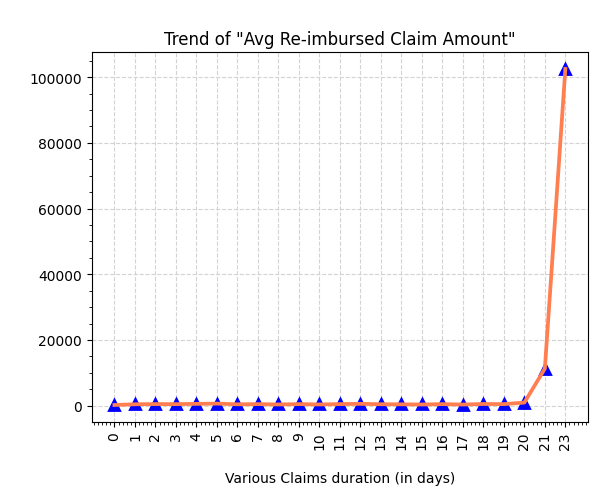

In [40]:
sns.pointplot(data=claim_clearance_amts, x='Claim_durations_in_days', y='Avg_Claim_Insc_Amount', 
                  color='blue', markers="^", linestyles="")
sns.pointplot(data=claim_clearance_amts, x='Claim_durations_in_days', y='Avg_Claim_Insc_Amount', 
                  color='coral', markers="", linestyles="-")
    # Providing the labels and title to the graph
plt.xticks(rotation=90)
plt.xlabel("\nVarious Claims duration (in days)")
plt.ylabel(" ")
plt.grid(which='major', linestyle="--", color='lightgrey')
plt.minorticks_on()
plt.title('\nTrend of "Avg Re-imbursed Claim Amount"')
plt.plot()

[]

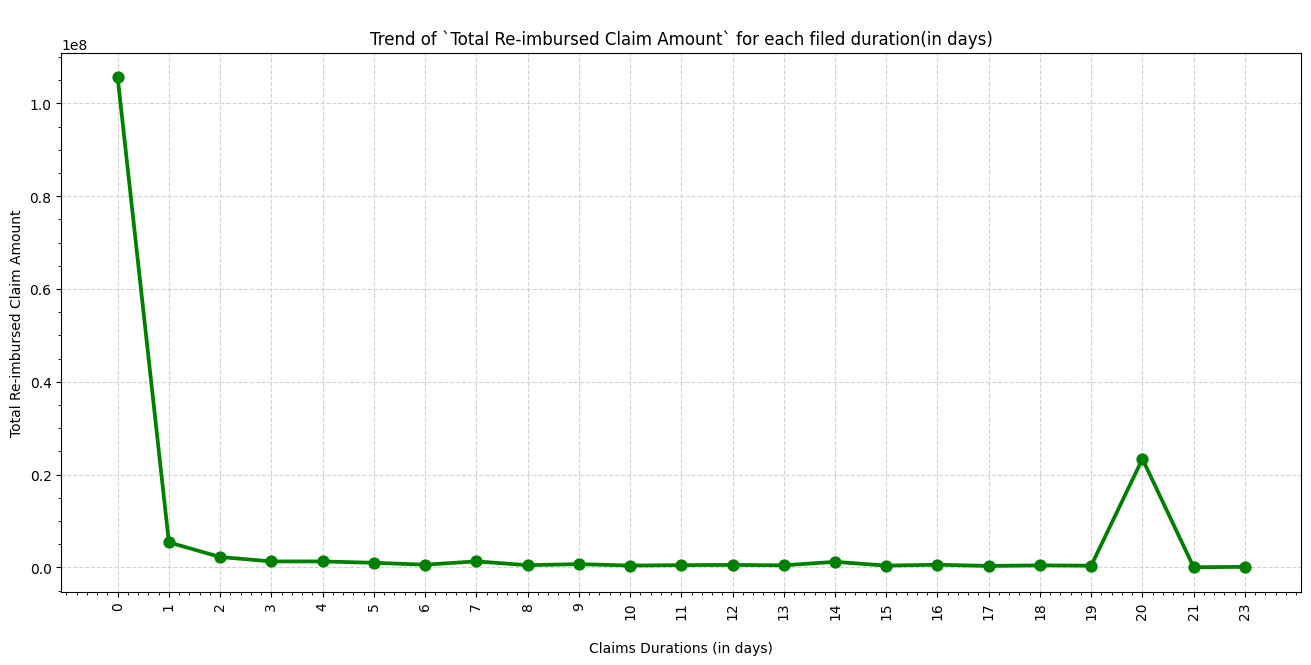

In [42]:
plt.figure(figsize=(16,7))
sns.pointplot(data=claim_clearance_amts, x='Claim_durations_in_days', y='All_Claims_Total_Amount', color='green')
    # Providing the labels and title to the graph
plt.xticks(rotation=90)
plt.xlabel("\nClaims Durations (in days)")
plt.ylabel("Total Re-imbursed Claim Amount")
plt.grid(which='major', linestyle="--", color='lightgrey')
plt.minorticks_on()
plt.title("\nTrend of `Total Re-imbursed Claim Amount` for each filed duration(in days)")
plt.plot()


**providers vs Total number of claims and reimbursement amount**

In [44]:
provider_tot_claims_filed = pd.DataFrame(df_outp.groupby(['Provider'])['ClaimID'].count())
provider_tot_reimbursed_amt = pd.DataFrame(df_outp.groupby(['Provider'])['InscClaimAmtReimbursed'].sum())

prv_tot_filed_claims_and_tot_reimb_amt = pd.merge(left=provider_tot_claims_filed, right=provider_tot_reimbursed_amt, how='inner',
                                                  left_on=provider_tot_claims_filed.index, right_on=provider_tot_reimbursed_amt.index)

prv_tot_filed_claims_and_tot_reimb_amt.columns = ['ProviderID', 'Tot_Claims_Filed', 'Tot_Re_Imbursed_Amt']
prv_tot_filed_claims_and_tot_reimb_amt.reset_index(drop=True,inplace=True)
prv_tot_filed_claims_and_tot_reimb_amt['Percentage_out_of_tot_reimb_amt'] = round((prv_tot_filed_claims_and_tot_reimb_amt['Tot_Re_Imbursed_Amt'] / df_outp['InscClaimAmtReimbursed'].sum()) * 100, 3)

provider_max_reimbursed_amt = pd.DataFrame(df_outp.groupby(['Provider'])['InscClaimAmtReimbursed'].max())
provider_max_reimbursed_amt.rename(columns={"InscClaimAmtReimbursed": "Max_Re_Imbursed_Amt"}, inplace=True)

prv_tot_filed_claims_tot_max_reimb_amt = pd.merge(left=prv_tot_filed_claims_and_tot_reimb_amt, 
                                                  right=provider_max_reimbursed_amt, how='inner',
                                                  left_on=prv_tot_filed_claims_and_tot_reimb_amt['ProviderID'], 
                                                  right_on=provider_max_reimbursed_amt.index)

prv_tot_filed_claims_tot_max_reimb_amt.drop(['key_0'], axis=1, inplace=True)
prv_tot_filed_claims_tot_max_reimb_amt['Diff_in_Tot_and_Max'] = prv_tot_filed_claims_tot_max_reimb_amt['Tot_Re_Imbursed_Amt'] - prv_tot_filed_claims_tot_max_reimb_amt['Max_Re_Imbursed_Amt']

prv_tot_filed_claims_tot_max_reimb_amt.head()

,ProviderID,Tot_Claims_Filed,Tot_Re_Imbursed_Amt,Percentage_out_of_tot_reimb_amt,Max_Re_Imbursed_Amt,Diff_in_Tot_and_Max
0,PRV51001,20,7640,0.005,1500,6140
1,PRV51003,70,32670,0.022,3300,29370
2,PRV51004,149,52170,0.035,3300,48870
3,PRV51005,1165,280910,0.189,4080,276830
4,PRV51007,69,14710,0.010,3300,11410


In [48]:
prv_tot_filed_claims_tot_max_reimb_amt.sort_values(by=['Diff_in_Tot_and_Max','Max_Re_Imbursed_Amt','Percentage_out_of_tot_reimb_amt'],
                                                   axis=0, inplace=True,
                                                   ascending=[True,False,False])
prv_tot_filed_claims_tot_max_reimb_amt.head(60)

,ProviderID,Tot_Claims_Filed,Tot_Re_Imbursed_Amt,Percentage_out_of_tot_reimb_amt,Max_Re_Imbursed_Amt,Diff_in_Tot_and_Max
82,PRV51119,1,95580,0.064,95580,0
2480,PRV54295,1,3300,0.002,3300,0
2485,PRV54302,1,3300,0.002,3300,0
3307,PRV55456,1,3300,0.002,3300,0
433,PRV51577,1,2100,0.001,2100,0
1473,PRV52954,1,2100,0.001,2100,0
4326,PRV56819,1,1900,0.001,1900,0
5010,PRV57762,1,1900,0.001,1900,0
521,PRV51689,1,1700,0.001,1700,0
3430,PRV55610,1,1700,0.001,1700,0


providers with 1 or 2 claims have highest reimbursements.

In [50]:
tot_re_imb_amt_for_prv_with_5orless_claims = prv_tot_filed_claims_tot_max_reimb_amt[prv_tot_filed_claims_tot_max_reimb_amt['Tot_Claims_Filed'] < 5] \
                                            ['Tot_Re_Imbursed_Amt'].sum()

pp_re_imb_amt_for_prv_with_5orless_claims = round((tot_re_imb_amt_for_prv_with_5orless_claims / df_outp['InscClaimAmtReimbursed'].sum()) * 100,2)
print("### Total Re-imbursed Amount for Providers with less than 5 filed claims is --> {} (0.52 Million). ###\n\
### And, this is {}% of Total Re-imbursed Claim Amount (148 Million). ###".format(tot_re_imb_amt_for_prv_with_5orless_claims, 
                                                                    pp_re_imb_amt_for_prv_with_5orless_claims))

### Total Re-imbursed Amount for Providers with less than 5 filed claims is --> 522910 (0.52 Million). ###
### And, this is 0.35% of Total Re-imbursed Claim Amount (148 Million). ###


**Summary**

**Inpatient**
1. 80% of the patients have been treated without admission.
2. There is an upward trend in reimbursement amount when claim duration increases
3. A large number of claims exist with claim duration between 3 to 4 days and then going down.
4. At provider level, a large % of claim amount is for on providers raising 1 or 2 claims. This could be sign of fraudulent trasnactions.

**Outpatinet**
1. 90% of claims are with claim period less than 2 days and with less than $3500
2. Reimbursement amount is higher for claims with duration 1 day and starts going down.
3. At provider level, a large % of claim amount is for on providers raising 1 or 2 claims. This could be sign of fraudulent trasnactions.

We need to join the 3 datasets to analyze more on Provider, physician and proc code analysis.